# Tutorial 1: Single-Target SPY Prediction with Professional Benchmarking

**Learning Objectives:**
- Understand the fundamentals of quantitative trading strategy development
- Learn walk-forward backtesting to avoid look-ahead bias
- Implement feature engineering with sector ETFs
- **NEW: Professional benchmarking with information ratios and excess returns**
- **NEW: Generate publication-quality PDF tear sheets**
- Use xarray for standardized results handling
- Calculate risk-adjusted performance metrics with extended data coverage (15+ years)

**Blue Water Macro Corp Educational Framework © 2025**

## Part 1: Setup and Data loading

### Import packages

In [17]:
import os
import sys
import time
import pickle
from pathlib import Path
from typing import List
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
import pandas_market_calendars as mcal

from vbase_utils.stats.pit_robust_betas import pit_robust_betas

In [18]:
sys.path.append('C:\\Users\\kvs39\\Desktop\\validityBase\\Dagster\\BWM\\bwm_capstone_simulator\\src')

# Import our custom utilities
from utils_simulate import (
    simplify_teos, log_returns, p_by_year, 
    create_results_xarray, plot_xarray_results,
    calculate_performance_metrics, get_educational_help
)

# NEW: Import professional benchmarking and simulation framework
from single_target_simulator import (
    load_and_prepare_data, Simulate, 
    SingleTargetBenchmarkManager, SingleTargetBenchmarkConfig,
    sim_stats_single_target, L_func_2, L_func_3, L_func_4
)
from plotting_utils import create_tear_sheet

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Welcome to the Blue Water Macro Quantitative Trading Tutorial!")
print("🎯 Goal: Predict SPY returns using sector ETF data with professional benchmarking")
print("🆕 NEW: Extended data coverage (2010-present) and PDF tear sheets!")

📚 Welcome to the Blue Water Macro Quantitative Trading Tutorial!
🎯 Goal: Predict SPY returns using sector ETF data with professional benchmarking
🆕 NEW: Extended data coverage (2010-present) and PDF tear sheets!


### Set configs

In [26]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# --- Constants ---
SECTOR_ETFS = ["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLRE", "XLK", "XLU"]
MARKET = "SPY"
ALL_TICKERS = [MARKET] + SECTOR_ETFS
WINDOW_SIZE = 400
WINDOW_TYPE = "expanding"
CACHE_DIR = "C:\\Users\\kvs39\\Desktop\\validityBase\\Dagster\\portfolio_spdrs\\data\\cache"
OUTPUT_DIR = "C:\\Users\\kvs39\\Desktop\\validityBase\\Dagster\\portfolio_spdrs\\data\\backtest"

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Caching Mechanism

In [9]:
def load_from_cache(ticker):
    path = os.path.join(CACHE_DIR, f"{ticker}.pkl")
    if os.path.exists(path):
        try:
            print(f"[{ticker}] Loading from cache...")
            return pickle.load(open(path, "rb"))
        except Exception as e:
            print(f"[{ticker}] Cache load error: {e}")
    return None

def save_to_cache(ticker, df):
    path = os.path.join(CACHE_DIR, f"{ticker}.pkl")
    try:
        pickle.dump(df, open(path, "wb"))
    except Exception as e:
        print(f"[{ticker}] Cache save error: {e}")

def safe_download(ticker, start="2000-01-01", end=None, max_retries=5, pause=5):
    cached = load_from_cache(ticker)
    if cached is not None and not cached.empty:
        return cached

    attempt = 0
    while attempt < max_retries:
        try:
            df = yf.download(
                ticker, start=start, end=end,
                progress=False, auto_adjust=True
            )
            if not df.empty:
                save_to_cache(ticker, df)
                return df
        except Exception as e:
            if "Rate limited" in str(e) or "YFRateLimitError" in str(e):
                print(f"[{ticker}] Rate limited. Sleeping {pause}s...")
                time.sleep(pause)
                pause *= 2
            else:
                print(f"[{ticker}] Unexpected error: {e}")
                break
        attempt += 1
    print(f"[{ticker}] Failed after {max_retries} retries.")
    return pd.DataFrame()

def smart_download(tickers, start="2000-01-01", end=None):
    all_data = []
    for t in tickers:
        df = safe_download(t, start=start, end=end)
        if df.empty:
            print(f"[{t}] Warning: empty dataframe returned.")
            continue
        s = df["Close"].copy()
        s.name = t
        all_data.append(s)

    if not all_data:
        raise RuntimeError("No valid data downloaded. Try again later.")

    return pd.concat(all_data, axis=1).sort_index()

### Test single simulation

In [19]:
def test_single_simulation():
    """Test a single simulation to verify the main script works."""
    
    print("Testing single simulation...")
    
    try:
        data_df = smart_download(ALL_TICKERS, start="2010-01-01")
        print("Data downloaded.")

        X = data_df[MARKET]
        y_multi = data_df[SECTOR_ETFS]

        if X.empty or y_multi.empty:
            print("❌ No data loaded - using cached results instead")
            return False
        
        print(f"Data loaded: X shape {X.shape}, y_multi shape {y_multi.shape}")
        return True, data_df
            
    except Exception as e:
        print(f"❌ Error during simulation: {e}")
        import traceback
        traceback.print_exc()
        return False, -1

### Execute (main)

In [20]:
if __name__ == "__main__":
    success, prices = test_single_simulation()
    if success:
        print("\nMain simulation script is working!")
    else:
        print("\nMain simulation script has issues")

Testing single simulation...
[SPY] Loading from cache...
[XLC] Loading from cache...
[XLY] Loading from cache...
[XLP] Loading from cache...
[XLE] Loading from cache...
[XLF] Loading from cache...
[XLV] Loading from cache...
[XLI] Loading from cache...
[XLB] Loading from cache...
[XLRE] Loading from cache...
[XLK] Loading from cache...
[XLU] Loading from cache...
Data downloaded.
Data loaded: X shape (1419,), y_multi shape (1419, 11)

Main simulation script is working!


## Part 2: Feature Engineering and Exploration

Let's convert prices to log returns and explore the relationships between sector ETFs and SPY:

In [12]:
# Setup Professional Benchmarking Framework
benchmark_config = SingleTargetBenchmarkConfig(
    include_transaction_costs=True,
    rebalancing_frequency='daily'
)

benchmark_manager = SingleTargetBenchmarkManager(
    target_etf=MARKET,
    feature_etfs=SECTOR_ETFS,
    config=benchmark_config
)

print("🎯 Professional Benchmarking Configured!")
print(f"   Available benchmarks: {list(benchmark_manager.benchmarks.keys())}")
print(f"   Target ETF: {MARKET}")
print(f"   Benchmark types:")
for name, benchmark in benchmark_manager.benchmarks.items():
    print(f"     - {name}: {benchmark.get_description()}")

🎯 Professional Benchmarking Configured!
   Available benchmarks: ['buy_and_hold', 'zero_return']
   Target ETF: SPY
   Benchmark types:
     - buy_and_hold: Buy-and-hold SPY
     - zero_return: Zero return (cash equivalent)


📈 Features shape: (1418, 11)
🎯 Target shape: (1418,)


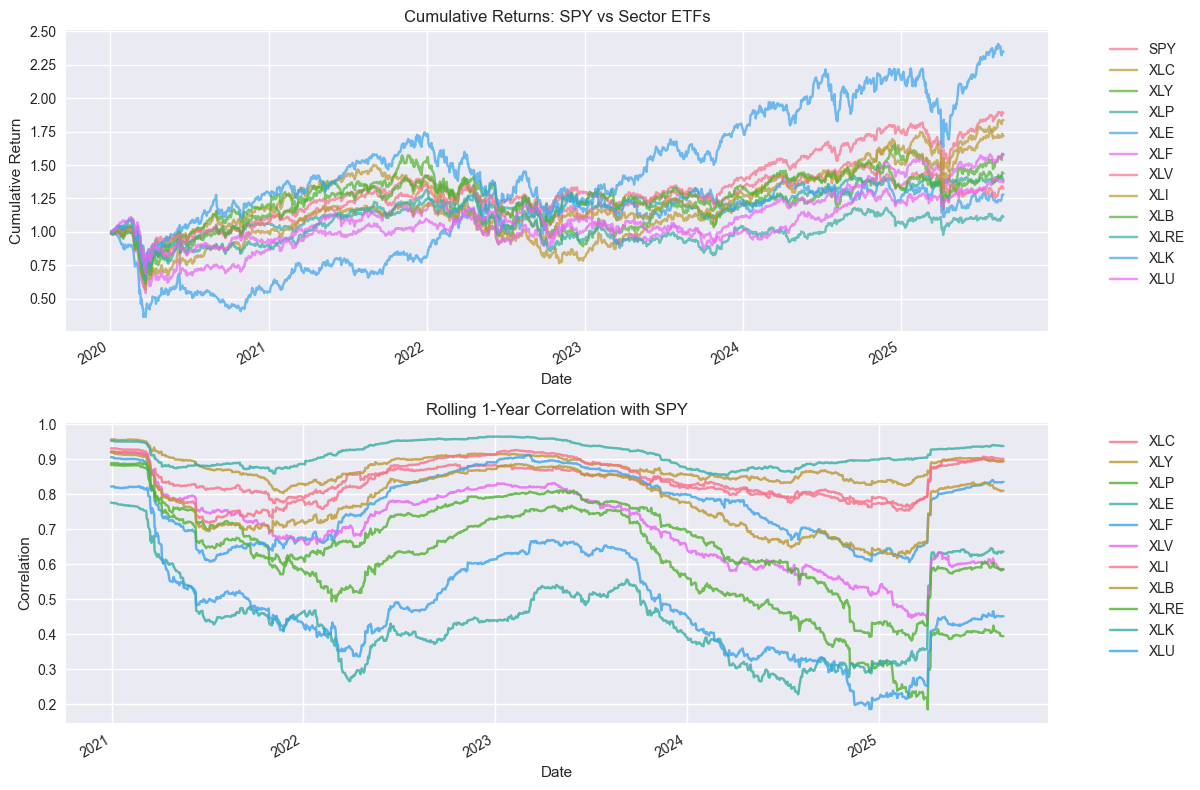

In [21]:
# Calculate log returns
returns = log_returns(prices).dropna()

# Separate features and target
X_features = returns[SECTOR_ETFS]
y_target = returns[MARKET]

print(f"📈 Features shape: {X_features.shape}")
print(f"🎯 Target shape: {y_target.shape}")

# Quick visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot cumulative returns
(1 + returns).cumprod().plot(ax=ax1, alpha=0.7)
ax1.set_title('Cumulative Returns: SPY vs Sector ETFs')
ax1.set_ylabel('Cumulative Return')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot rolling correlation with SPY
rolling_corr = X_features.rolling(252).corr(y_target).dropna()
rolling_corr.plot(ax=ax2, alpha=0.8)
ax2.set_title('Rolling 1-Year Correlation with SPY')
ax2.set_ylabel('Correlation')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Feature analysis by year

🔍 Analyzing feature importance by year...
Analysis period: 2020-01-03 00:00:00 to 2025-08-25 00:00:00


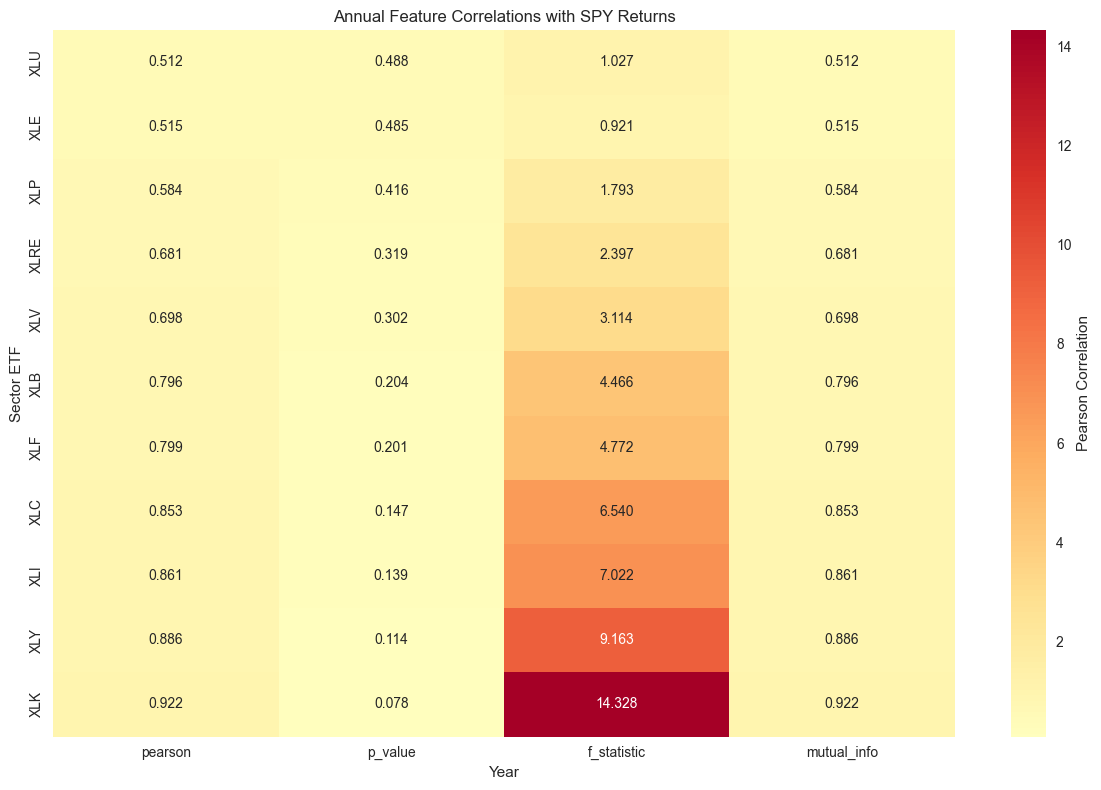


🏆 Most consistent predictors (by average absolute correlation):
  XLK: 4.063
  XLY: 2.762
  XLI: 2.221
  XLC: 2.098
  XLF: 1.643


In [22]:
# Analyze feature importance by year
print("🔍 Analyzing feature importance by year...")
yearly_correlations = p_by_year(X_features, y_target)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(yearly_correlations, annot=True, cmap='RdYlBu_r', center=0, 
           fmt='.3f', cbar_kws={'label': 'Pearson Correlation'})
plt.title('Annual Feature Correlations with SPY Returns')
plt.xlabel('Year')
plt.ylabel('Sector ETF')
plt.tight_layout()
plt.show()

# Find most stable predictors
mean_abs_corr = yearly_correlations.abs().mean(axis=1).sort_values(ascending=False)
print("\n🏆 Most consistent predictors (by average absolute correlation):")
for etf, corr in mean_abs_corr.head(5).items():
    print(f"  {etf}: {corr:.3f}")

## Part 3: Professional Walk-Forward Simulation with Multiple Position Strategies

In [27]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from utils_simulate import EWMTransformer

# Define position sizing strategies to test
position_strategies = [
    ('Binary', L_func_2),      # Simple binary: +1 or -1
    ('Quartile', L_func_3),    # Quartile-based: 0, 0.5, 1.5, 2.0
    ('Proportional', L_func_4) # Proportional to prediction strength
]

print("🚀 Running professional simulation with multiple strategies...")
print(f"📅 Period: {prices.index.min()} to {prices.index.max()}")
print(f"🔄 Position strategies: {[name for name, _ in position_strategies]}")

X = prices[SECTOR_ETFS]
y = prices[MARKET]

# Run simulations
regout_list = []
sweep_tags = []

for pos_name, pos_func in position_strategies:
    print(f"\n🎯 Running {pos_name} strategy...")
    
    # Create ML pipeline with exponential smoothing
    pipe = Pipeline([
        ('ewm', EWMTransformer(halflife=4)),
        ('ridge', Ridge(alpha=1.0))
    ])
    
    # Run simulation
    regout = Simulate(
        X, y, 
        window_size=WINDOW_SIZE,
        window_type=WINDOW_TYPE,
        pipe_steps=pipe,
        L_func=pos_func,
        tag=f"ridge_ewm4_{pos_name.lower()}"
    )
    
    regout_list.append(regout)
    sweep_tags.append(f"ridge_ewm4_{pos_name.lower()}")
    
    print(f"   ✅ Completed {len(regout)} predictions")

print("\n✅ All simulations completed!")
print(f"📊 Total strategies: {len(regout_list)}")
print(f"📈 Predictions per strategy: {len(regout_list[0])}")

🚀 Running professional simulation with multiple strategies...
📅 Period: 2020-01-02 00:00:00 to 2025-08-25 00:00:00
🔄 Position strategies: ['Binary', 'Quartile', 'Proportional']

🎯 Running Binary strategy...


TypeError: Simulate() got an unexpected keyword argument 'L_func'